In [1]:
# 라이브러리 불러오기
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# 1) 사전 학습이 무엇인지 설명을 주석으로 코드 내 첫 부분에 추가하시오

사전 훈련된 네트워크는 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크이다. 원본 데이터셋이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 학습된 특성의 계층 구조는 실생활에 적용할 수 있는 모델로 효율적인 역할을 할 수 있다. 새로운 문제가 원래 작업과 완전히 다른 클래스에 대한 것이더라도 이런 특성은 많은 컴퓨터 비전 문제에 유용하다. 예를 들어 동물과 생활 용품이 같이 있는 이미지 데이터셋에 훈련된 네트워크라면, 이 네트워크를 가지고 가구 아이템을 식별하는 등의 다른 용도로 사용할 수 있다.

# 2) 데이터를 다운 받고 첫 9개 이미지에 대해 레이블을 포함하여 시각화하시오.

In [2]:
# 데이터 다운로드
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 2s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
# 검증용 데이터셋 설정
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


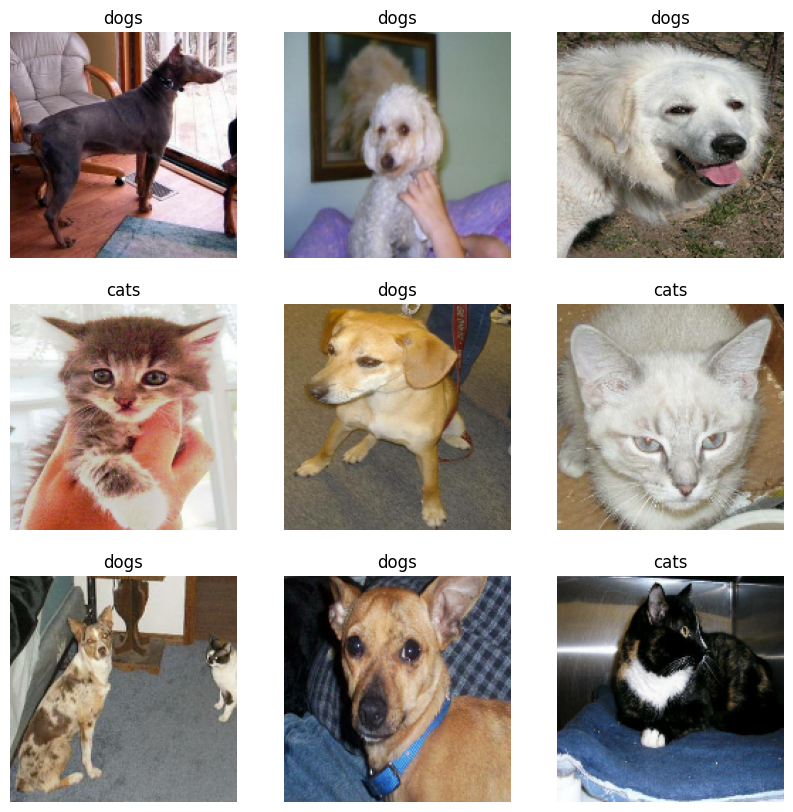

In [4]:
class_names = train_dataset.class_names

# 첫 9개 이미지에 대하여 레이블을 포함하여 시각화
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
# 검증용 데이터셋에서 사용할 수 있는 배치 수를 확인한 뒤 20%를 테스트 데이터셋에 할당
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
# 6개의 배치가 테스트 데이터셋에 할당되었음을 확인할 수 있음
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [7]:
# 버퍼링된 프리 페치 사용
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# 3) 데이터 증강 기법을 활용하여 성능을 높이시오.

데이터 증강에는 여러가지 기법이 있는데, 여기서는 좌우 상하 대칭으로 뒤집기, 각도 변환, 명도와 채도를 조금씩 변화하게 했고 노이즈까지 추가하여 모델이 보다 Robust해 질 수 있도록 데이터를 증강함

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(0.1),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
  tf.keras.layers.GaussianNoise(0.1)
])

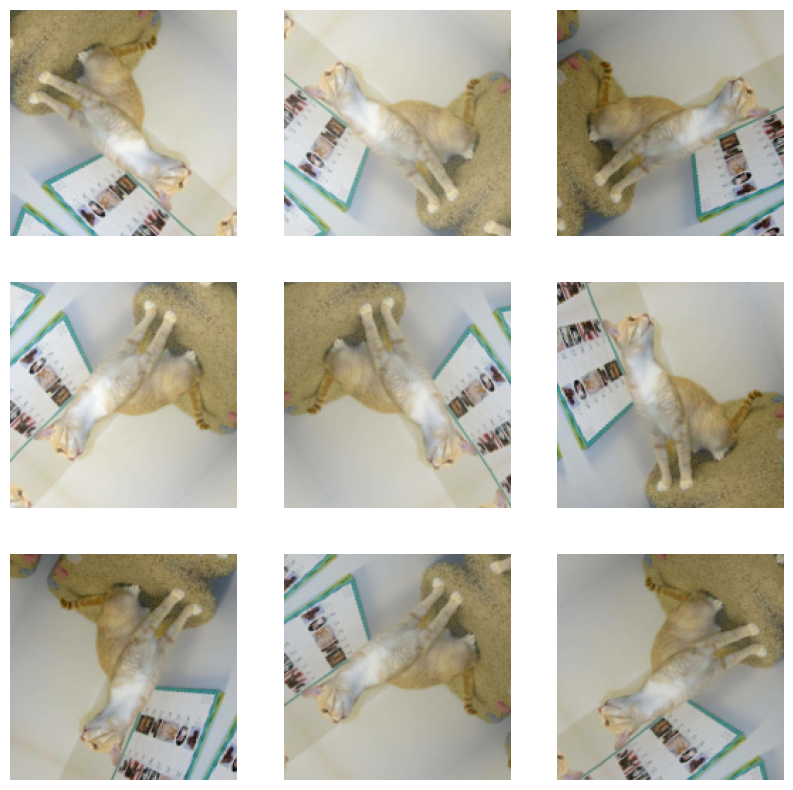

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# 4) 이미지 데이터에 적합한 픽셀 값 재조정(정규화)를 진행하시오.

In [10]:
# 기본 모델로 사용한 MobileNetV2 다운로드
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# 5) 사전 훈련된 컨볼루션 네트워크로부터 기본 모델을 생성하시오.

**MobileNetV2란?**
---
MobileNet V2는 이전 모델인 MobileNet을 개선한 네트워크이다. MobileNet V2는 임베디드 디바이스 또는 모바일 장치를 타겟으로 하는 단순한 구조의 경량화 네트워크를 설계하는데 초점이 맞춰져 있다.

MobileNet V2는 Depthwise-Separable Convolution(깊이별 분리 콘벌루션)을 주로 사용하고 width/resolution multiplyer를 사용해 정확도와 모델 크기를 trade-off한다.

또한 MobileNet v2는 Inverted Residual block이라는 구조를 이용해 네트워크를 구성한다.

In [12]:
# 사전 훈련된 MobileNet V2라는 모델로부터 베이스 모델을 생성
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


각 160x160x3 이미지를 5x5x1280 개의 특징 블록으로 변환함

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)




---


- 사전 훈련된 네트워크를 사용하는 방법으로는 특징 추출(Feature Extract)와 미세 조정(Fine tuning)이 있음
- 아래부터 두 가지 프로세스를 차례로 사용하여 모델의 성능 개선을 추구함

# 6) 특징 추출의 과정을 수행하시오.

In [14]:
# 레이어의 가중치가 훈련 중에 업데이트 되는 것을 방지함(베이스 모델 고정)
base_model.trainable = False

In [15]:
# 모델 구조 살펴보기
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [16]:
# 전역 평균 풀링 레이어를 생성해서 각 Feature Map의 평균을 계산하고 결과를 반환함
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# 각 Feature Map에 대한 평균을 구하여 feature_batch_average에 저장
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
# 출력 뉴런의 수가 1임을 의미. 즉, 출력 뉴런이 모델이 예측하는 값 하나임
prediction_layer = tf.keras.layers.Dense(1)
# 앞서 구한 각각의 Feature Map애 대한 평균값을 활용하여 모델의 예측값을 계산함
prediction_batch = prediction_layer(feature_batch_average)
# 예측값을 담을 텐서의 형태를 출력함
print(prediction_batch.shape)

(32, 1)


In [18]:
# Keras의 Functional API를 활용하여 모델 구축
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# 7) 모델 컴파일하고 모델을 훈련시키며 학습 곡선을 분석하시오.

개와 고양이 두 개의 클래스로 분류를 해야 함
- 기존 모델은 선형 출력 제공. 따라서 모델의 로짓값을 구할 수 있도록 from_logits=True 설정
- 이진 분류를 위해 BinaryCrossentrophy를 손실함수 값으로 설정

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

**<모델 설명>**

InputLayer : 입력 형태를 통해 이미지의 높이와 너비가 각각 160이며 색 채널이 3개. 즉 RBG를 의미함을 알 수 있음

Sequential Layer : 전이 학습을 위한 모델의 시작 부분. mobilenetv2 모델을 불러옴

tf.math.truediv, tf.math.subtract Layer : 이미지 데이터의 전처리를 진행. [0,255] 범위의 픽셀 값을 모델에 사용할 수 있도록 [0,1] 범위로 조정함

MobilenetV2 Layer : MobilenetV2 아키텍처로 구성된 합성곱 신경망임. 이미지의 특성을 추출하는데 사용되며, 5*5 크기의 Feature Map을 1280개의 채널로 나타냄.

Global Average Pooling2d Layer : 각 채널에 대한 평균을 계산하는 글로벌 평균 풀링 레이어

Dropout Layer : 드롭아웃을 통한 과적합 장지

Dense Layer : 출력 뉴런이 1개임(=출력하는 결과물이 1개)
---
모델의 총 파라미터 개수는 2259265개이나 이 중 훈련이 가능한 파라미터의 개수는 1281개임. 즉, 1281개 외의 파라미터는 이미 사전에 훈련이 되어 제공된 파라미터임.

In [21]:
# 훈련 가능한 변수는 가중치와 편향으로 나뉨
len(model.trainable_variables)

2

모델 훈련

In [22]:
# epoch를 10으로 설정
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 7s 43ms/step - loss: 0.6692 - accuracy: 0.5854


In [24]:
# 최초의 손실 값은 0.67, 정확도는 0.59로 출력됨
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.67
initial accuracy: 0.59


- 이후 모델의 학습 진행. 10번의 Epoch 이후 Loss는 0.2990, Accuracy는 0.8590을 출력함
- 검증용 데이터셋의 값들을 보아도 과적합이 의심되지 않는다.

In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 11s 62ms/step - loss: 0.7109 - accuracy: 0.5830 - val_loss: 0.4895 - val_accuracy: 0.7314
Epoch 2/10
63/63 [==============================] - 4s 56ms/step - loss: 0.5654 - accuracy: 0.6825 - val_loss: 0.3793 - val_accuracy: 0.8106
Epoch 3/10
63/63 [==============================] - 5s 71ms/step - loss: 0.4931 - accuracy: 0.7560 - val_loss: 0.3125 - val_accuracy: 0.8614
Epoch 4/10
63/63 [==============================] - 4s 63ms/step - loss: 0.4252 - accuracy: 0.7925 - val_loss: 0.2683 - val_accuracy: 0.8762
Epoch 5/10
63/63 [==============================] - 4s 55ms/step - loss: 0.3799 - accuracy: 0.8145 - val_loss: 0.2277 - val_accuracy: 0.8985
Epoch 6/10
63/63 [==============================] - 4s 65ms/step - loss: 0.3815 - accuracy: 0.8170 - val_loss: 0.2111 - val_accuracy: 0.9121
Epoch 7/10
63/63 [==============================] - 5s 69ms/step - loss: 0.3456 - accuracy: 0.8315 - val_loss: 0.1937 - val_accuracy: 0.9257
Epoch 8/10
6

- 훈련용 데이터셋과 검증용 데이터셋의 정확도, 손실함수 값을 확인할 수 있는 차트를 통해 추이를 비교분석한다.

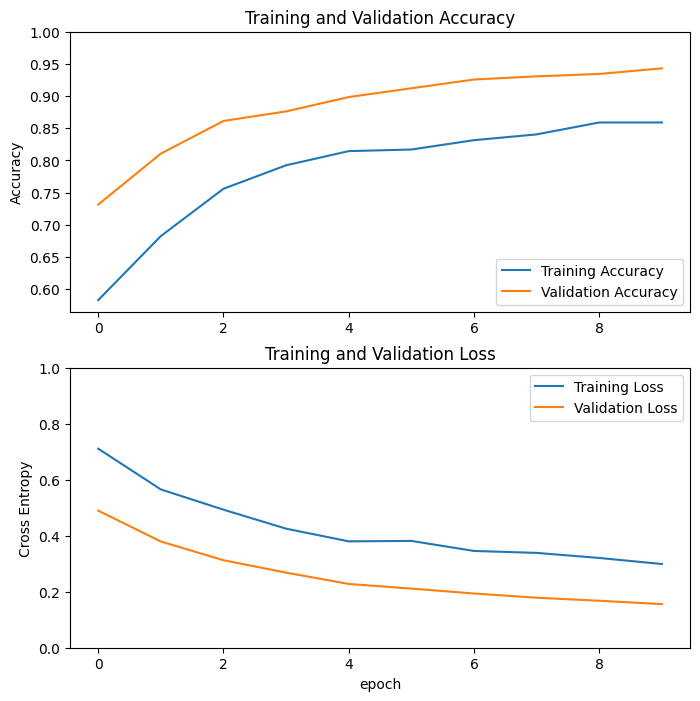

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

- Epoch를 거듭할수록 정확도와 손실함수 값이 각각 증가, 감소하며 성능이 개선되고 있는 것을 확인할 수 있다.
- Validation data의 성능이 좀 더 좋은 것으로 나타나는데, 과적합 방지를 위해 사용되는 배치 정규화 레이어와 드롭아웃 레이어는 train 과정에만 적용되기 때문이다.

# 8) 미세 조정 과정을 수행하고 성능 평가 및 예측을 진행하며 기존 모델과 달라진 점을 서술하시오.

## 미세 조정(Fine tuning)
: 기존에 학습되어져 있는 모델을 기반으로 아키텍쳐를 새로운 목적(나의 이미지 데이터에 맞게)변형하고 이미 학습된 모델 가중치로 부터 학습을 업데이트하는 방법
- 이미 존재하는 모델에 추가 데이터를 투입하여 파라미터를 업데이트하는 것을 말함
- 사용 시 아래의 사항을 준수해야 함
  - 과적합(Overfitting)을 방지해야 함
  - 학습률(Learning rate)을 조절해야 함
  - 파라미터 초기화(Parameter Initialization)를 신중히 해야 함

### 최상위 층 고정 해제하기


base_model을 고정 해제하고 맨 아래 층을 훈련 할 수 없도록 설정하면 됩니다. 그런 다음 모델을 다시 컴파일하고(변경 사항을 적용하기 위해서) 훈련을 다시 시작해야 합니다.

In [27]:
base_model.trainable = True

In [30]:
# base_model의 레이어 개수 확인
print("Number of layers in the base model: ", len(base_model.layers))

# base_model의 100번째 레이어부터 파인튜닝을 시작함
fine_tune_at = 100

# 기존의 훈련된 상태의 레이어는 값이 변하지 않도록 고정시키고, 100번째 레이어 이후의 레이어만 파인튜닝을 진행함
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### 모델 컴파일

파인 튜닝 시 훈련해야 할 모델의 크기가 훨씬 커지므로, 가중치 조정을 위해서는 보다 낮은 적절한 학습률을 사용해야만 모델의 과적합을 방지할 수 있음. 따라서 기존의 학습률의 1/10값을 사용함

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [32]:
# 기존에는 trainable_variables가 단 두 개였지만, 파인 튜닝을 위해 추가적으로 레이어를 사용하기에 trainable_variables가 158개로 증가함
len(model.trainable_variables)

158

### 모델 훈련 계속하기

이미 훈련된 epoch에 추가하여 파인튜닝용 epoch만큼 모델의 훈련을 진행함

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 32s 157ms/step - loss: 0.2565 - accuracy: 0.8840 - val_loss: 0.0919 - val_accuracy: 0.9765
Epoch 11/20
63/63 [==============================] - 7s 107ms/step - loss: 0.2009 - accuracy: 0.9120 - val_loss: 0.0747 - val_accuracy: 0.9790
Epoch 12/20
63/63 [==============================] - 8s 112ms/step - loss: 0.1777 - accuracy: 0.9255 - val_loss: 0.0600 - val_accuracy: 0.9765
Epoch 13/20
63/63 [==============================] - 9s 133ms/step - loss: 0.1498 - accuracy: 0.9375 - val_loss: 0.0609 - val_accuracy: 0.9765
Epoch 14/20
63/63 [==============================] - 7s 107ms/step - loss: 0.1442 - accuracy: 0.9415 - val_loss: 0.0579 - val_accuracy: 0.9790
Epoch 15/20
63/63 [==============================] - 8s 115ms/step - loss: 0.1177 - accuracy: 0.9510 - val_loss: 0.0636 - val_accuracy: 0.9715
Epoch 16/20
63/63 [==============================] - 9s 132ms/step - loss: 0.1269 - accuracy: 0.9450 - val_loss: 0.0679 - val_accuracy: 0.970

 - 기존의 에포크를 마친 이후 손실함수 값이 0.2990, 정확도가 0.8590이었으나 파인 튜닝을 통해 손실함수 값이 0.0961, 정확도가 0.9640으로 성능이 개선되었음을 확인할 수 있다.

파인 튜닝을 진행한 후의 정확도, 손실의 학습 곡선 살펴보기

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

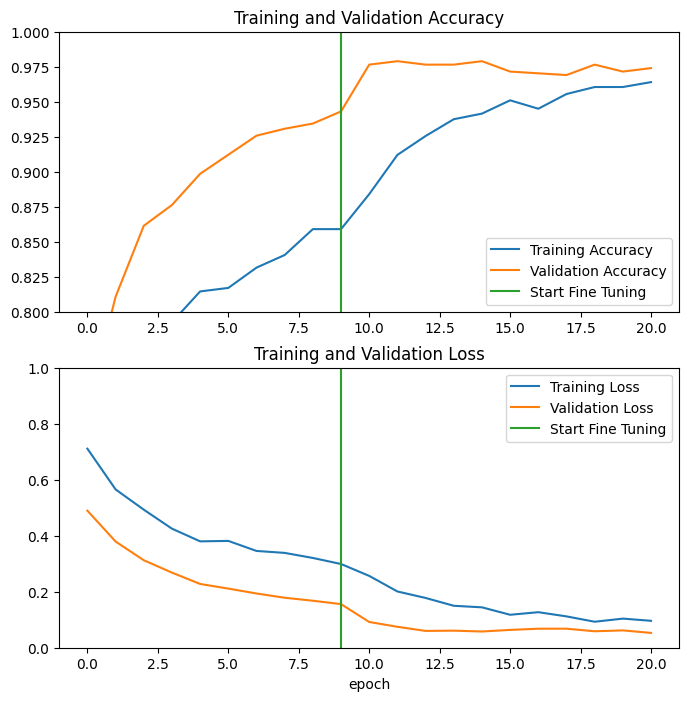

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

파인 튜닝이 시작된 직후에는 성능이 크게 개선되었으나 이후 정확도의 증가세가 이어지지 않고 반감하는 현상을 보임

-> 훈련용 데이터셋의 크기가 작기 때문에 과적합이 다소 발생한 것으로 확인됨
- 따라서 epoch의 조정, 혹은 추가 데이터셋의 확보가 필요함

### 평가 및 예측

최종적으로 테스트 데이터셋을 통해 모델을 평가함

손실함수 값과 정확도가 기존의 훈련 데이터셋에 적용한 값과 큰 차이가 없는 것을 통하여 과적합 없이 잘 훈련된 모델임을 확인할 수 있음


---



손실함수 값은 0.0336, 정확도는 0.9844가 출력됨

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 37ms/step - loss: 0.0336 - accuracy: 0.9844
Test accuracy : 0.984375


훈련된 모델을 통해 새로운 사진(입력 데이터)을 넣고 모델의 예측 성능을 파악함

Predictions:
 [1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0]
Labels:
 [1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0]


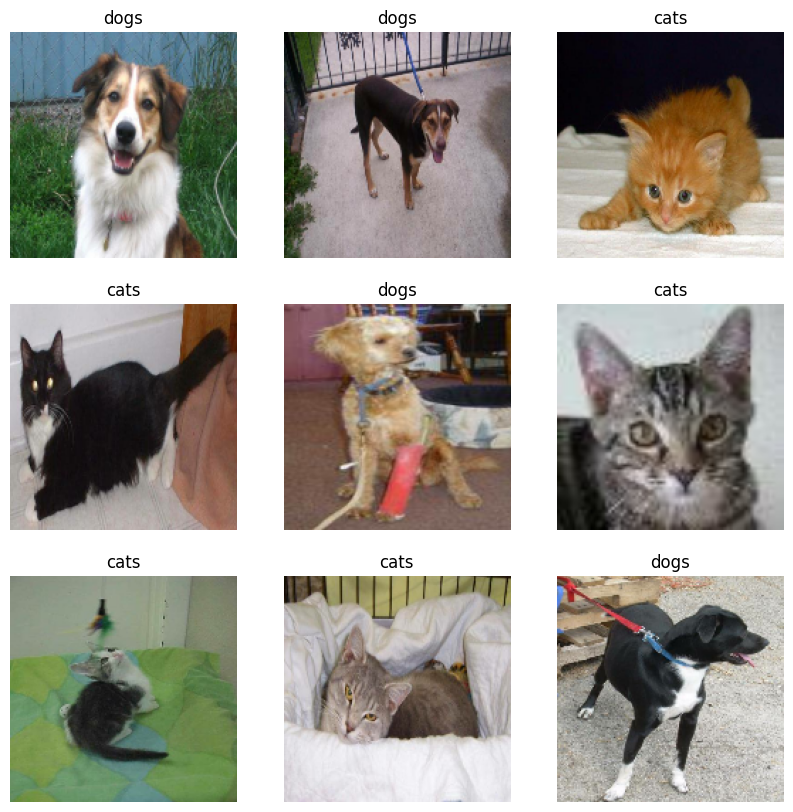

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Predictions :

 [1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0]

Labels :

 [1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0]


---



 예측값과 레이블값이 정확하게 일치함. 이미지에 나와있는 고양이와 개를 정확하게 인식하고 있음을 확인하고 있음. 물론 테스트 정확도가 0.984375이기에 매우 높은 성능이나 잘못 인식하는 경우가 발생할 수도 있음

